In [1]:
#log into kaggle to access dataset
import os
from collections import defaultdict
import kagglehub
import numpy as np
from tqdm import tqdm
import pandas as pd
import networkx as nx

In [2]:
#please ikke offentliggør min api key. 
os.environ['KAGGLE_USERNAME'] = "marcusgaleajacobsen"
os.environ['KAGGLE_KEY'] = "32a3003f52c97053841ea46c492128dc"

In [3]:
# Download latest version
datapath = kagglehub.dataset_download("netflix-inc/netflix-prize-data")
os.listdir(datapath)

['combined_data_1.txt',
 'combined_data_2.txt',
 'combined_data_3.txt',
 'combined_data_4.txt',
 'movie_titles.csv',
 'probe.txt',
 'qualifying.txt',
 'README']

In [4]:
from src.structures import Movie, User
from src.data_methods import read_movies,read_viewers, dict_to_df, read_df

n_lines = 5_000_000 #number of reviews to read
datafiles = ["combined_data_1.txt"]#, "combined_data_2.txt", "combined_data_3.txt", "combined_data_4.txt"]
with_tqdm = False #set to True to see progress bar (reduce speed)

movies = read_movies(datapath)
users = read_viewers(datapath, movies, datafiles = datafiles, with_tqdm= with_tqdm, n_lines=n_lines) #read only 100000 reviews for now

# Data Visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

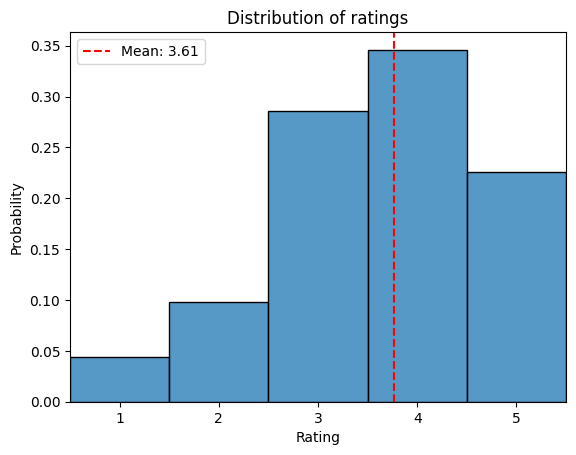

In [6]:
ratings = []

for user in users.values():
    ratings.extend(list(user.ratings.values()))
    
#plot the distribution of ratings as probability
# Plot the distribution of ratings as probability
sns.histplot(ratings, bins=5, stat="probability")
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.title("Distribution of ratings")
plt.xticks([1.4, 2.2, 3, 3.8, 4.6], [1, 2, 3, 4, 5])
plt.axvline(np.mean(ratings), color="red", linestyle="--", label=f"Mean: {np.mean(ratings):.2f}")
plt.legend()
plt.xlim(1, 5)
plt.show()

In [7]:
splits = {'train': 'train.csv', 'validation': 'validation.csv', 'test': 'test.csv'}
genres = pd.read_csv("hf://datasets/jquigl/imdb-genres/" + splits["train"])

# Split the 'movie title - year' column into 'movie title' and 'year'
genres[['movie title', 'year']] = genres['movie title - year'].str.rsplit(' - ', n=1, expand=True)

# Drop the original 'movie title - year' column
genres.drop(columns=['movie title - year'], inplace=True)

#set movie title as index
genres.set_index('movie title', inplace=True)

#remove duplicate movies
genres = genres[~genres.index.duplicated(keep='first')]

for i in tqdm(range(1, len(movies)+1)):
    movie = movies[str(i)]

    try:
        if not genres.loc[movie.title].empty:
            if genres.loc[movie.title].year == movie.year:
                if type(genres.loc[movie.title]) == pd.Series:
                    movie.genres = genres.loc[movie.title]['expanded-genres'].split(", ")
                else:
                    movie.genres = genres.loc[movie.title]['expanded-genres'].iloc[0].split(", ")
    except KeyError:
        pass

g_count = 0
for movie in movies.values():
    if movie.genres:
        g_count += 1

print(f"Movies with genres: {g_count}/{len(movies)}")

100%|██████████| 996/996 [00:00<00:00, 4184.81it/s]

Movies with genres: 268/996


In [8]:
genres = defaultdict(int)

for movie in movies.values():
    for genre in movie.genres:
        genres[genre] += 1

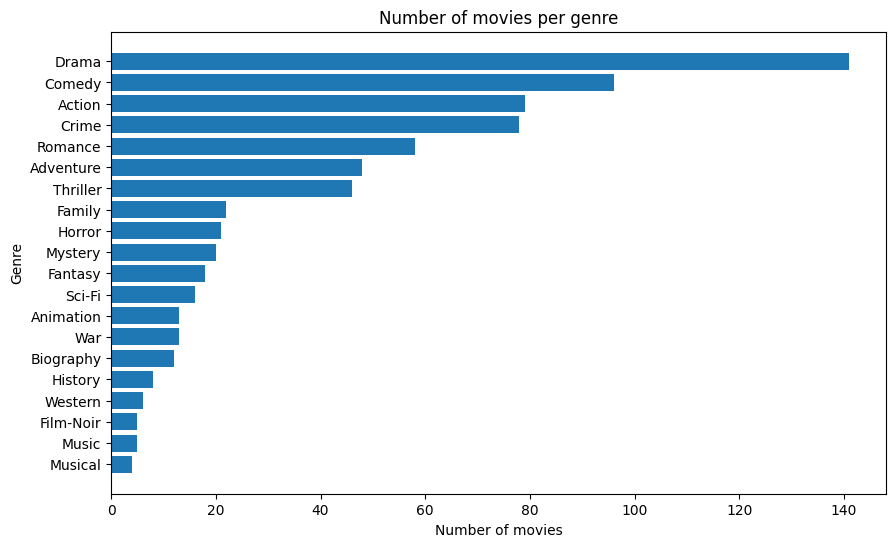

In [9]:
#plot horizontal histogram of genres, sort by number of movies
genres = dict(sorted(genres.items(), key=lambda x: x[1], reverse=False))

plt.figure(figsize=(10, 6))
plt.barh(list(genres.keys()), list(genres.values()))
plt.xlabel("Number of movies")
plt.ylabel("Genre")
plt.title("Number of movies per genre")
plt.show()

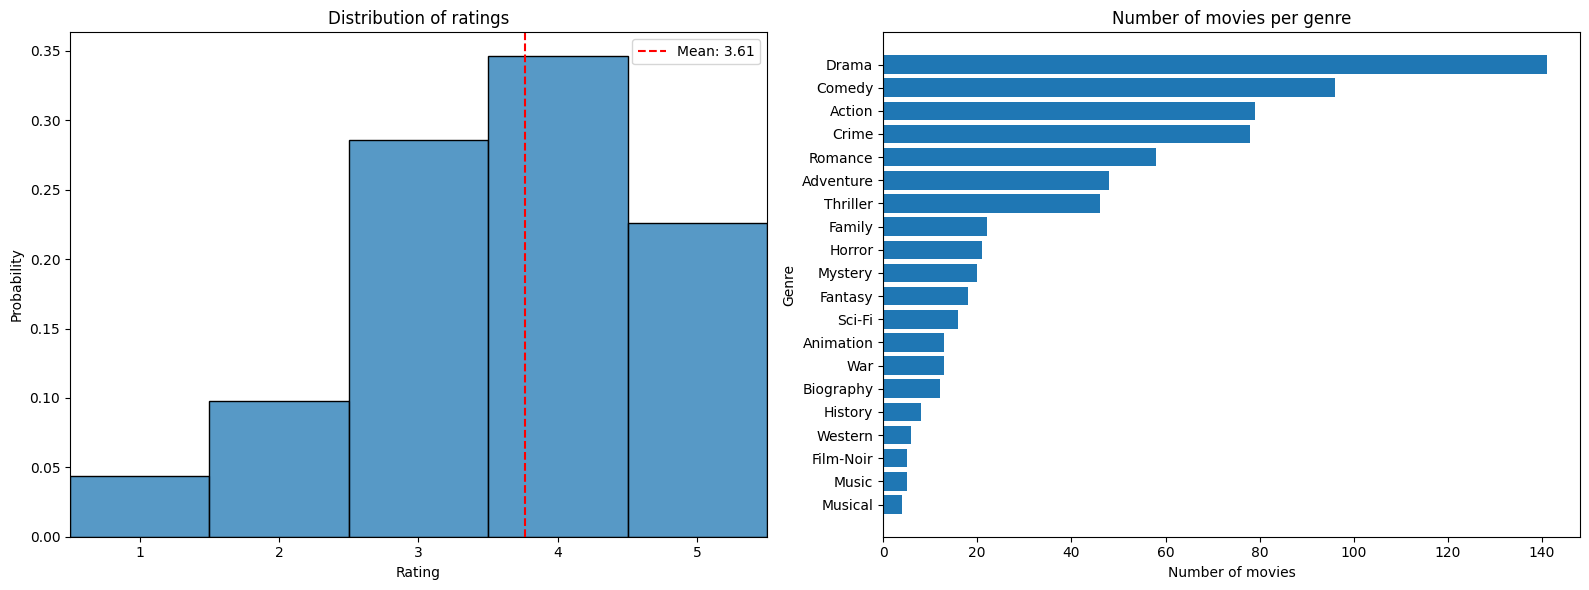

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming ratings and genres are already defined

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the distribution of ratings as probability
sns.histplot(ratings, bins=5, stat="probability", ax=axes[0])
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Probability")
axes[0].set_title("Distribution of ratings")
axes[0].set_xticks([1.4, 2.2, 3, 3.8, 4.6])
axes[0].set_xticklabels([1, 2, 3, 4, 5])
axes[0].axvline(np.mean(ratings), color="red", linestyle="--", label=f"Mean: {np.mean(ratings):.2f}")
axes[0].legend()
axes[0].set_xlim(1, 5)

# Plot horizontal histogram of genres, sort by number of movies
genres = dict(sorted(genres.items(), key=lambda x: x[1], reverse=False))
axes[1].barh(list(genres.keys()), list(genres.values()))
axes[1].set_xlabel("Number of movies")
axes[1].set_ylabel("Genre")
axes[1].set_title("Number of movies per genre")

plt.tight_layout()
plt.show()

100%|██████████| 404468/404468 [00:20<00:00, 19872.98it/s] 


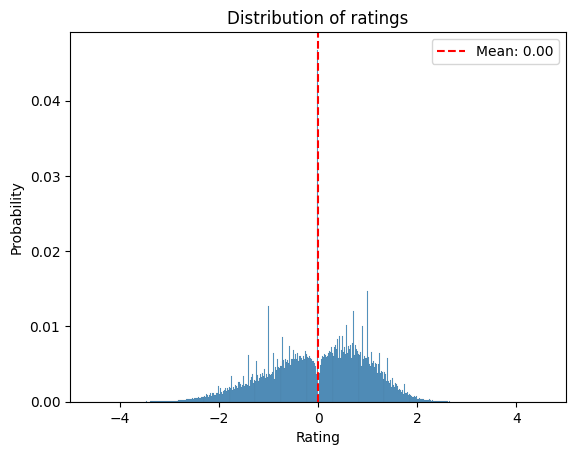

In [11]:
normalized_ratings = []

for user in tqdm(users.values()):
    user.normalize_ratings()
    normalized_ratings.extend(list(user.ratings.values()))
    
#plot the distribution of ratings as probability
# Plot the distribution of ratings as probability
sns.histplot(normalized_ratings, bins=1000, stat="probability")
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.title("Distribution of ratings")
# plt.xticks([1.4, 2.2, 3, 3.8, 4.6], [1, 2, 3, 4, 5])
plt.xlim(-5, 5)
plt.axvline(np.mean(normalized_ratings), color="red", linestyle="--", label=f"Mean: {np.mean(normalized_ratings):.2f}")
plt.legend()
plt.show()

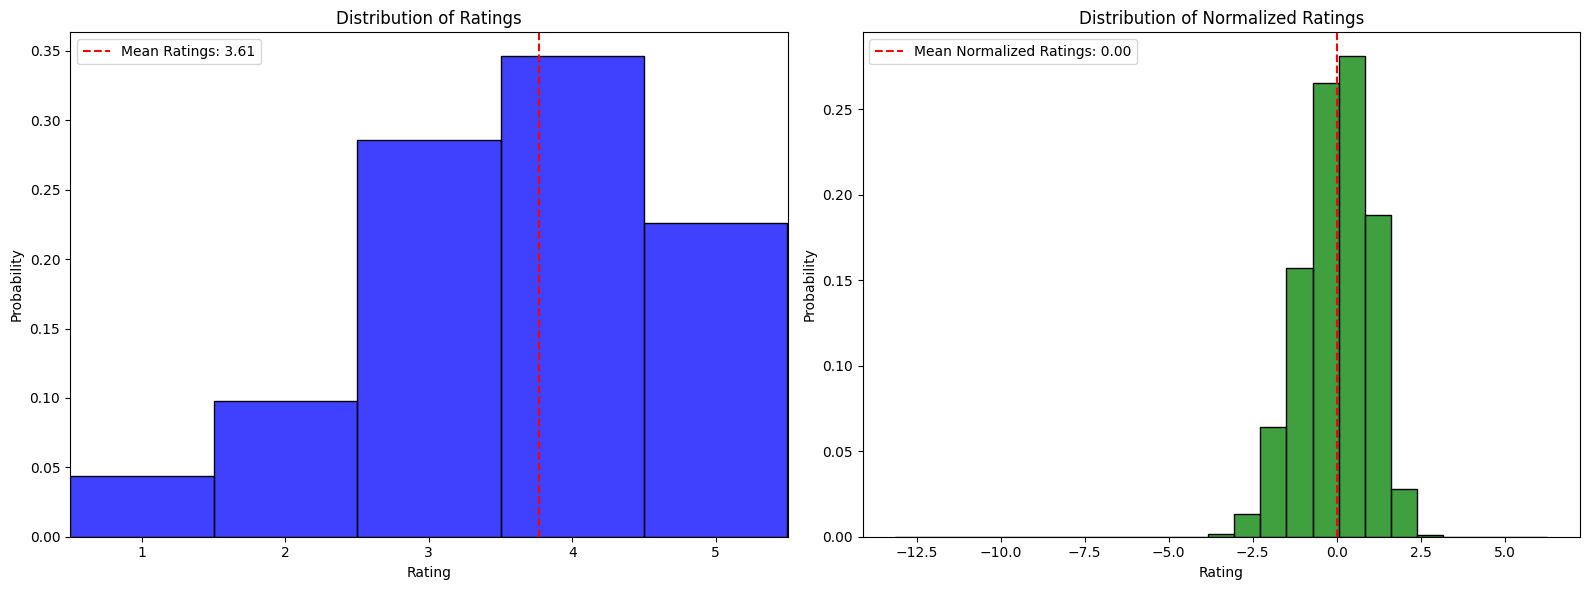

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming ratings and normalized_ratings are already defined

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the distribution of ratings
sns.histplot(ratings, bins=5, stat="probability", color='blue', ax=axes[0])
axes[0].axvline(np.mean(ratings), color="red", linestyle="--", label=f"Mean Ratings: {np.mean(ratings):.2f}")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Probability")
axes[0].set_title("Distribution of Ratings")
axes[0].legend()
axes[0].set_xticks([1.4, 2.2, 3, 3.8, 4.6])
axes[0].set_xticklabels([1, 2, 3, 4, 5])
axes[0].set_xlim(1, 5)

# Plot the distribution of normalized ratings
sns.histplot(normalized_ratings, bins=25, stat="probability", color='green', ax=axes[1])
axes[1].axvline(np.mean(normalized_ratings), color="red", linestyle="--", label=f"Mean Normalized Ratings: {np.mean(normalized_ratings):.2f}")
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("Probability")
axes[1].set_title("Distribution of Normalized Ratings")
axes[1].legend()

plt.tight_layout()
plt.show()

In [13]:
movies

defaultdict(src.structures.Movie,
            {'1': Movie(1, Dinosaur Planet, 2003) seen by 547 users,
             '2': Movie(2, Isle of Man TT 2004 Review, 2004) seen by 145 users,
             '3': Movie(3, Character, 1997) seen by 2012 users,
             '4': Movie(4, Paula Abdul's Get Up & Dance, 1994) seen by 142 users,
             '5': Movie(5, The Rise and Fall of ECW, 2004) seen by 1140 users,
             '6': Movie(6, Sick, 1997) seen by 1019 users,
             '7': Movie(7, 8 Man, 1992) seen by 93 users,
             '8': Movie(8, What the #$*! Do We Know!?, 2004) seen by 14910 users,
             '9': Movie(9, Class of Nuke 'Em High 2, 1991) seen by 95 users,
             '10': Movie(10, Fighter, 2001) seen by 249 users,
             '11': Movie(11, Full Frame: Documentary Shorts, 1999) seen by 198 users,
             '12': Movie(12, My Favorite Brunette, 1947) seen by 546 users,
             '13': Movie(13, Lord of the Rings: The Return of the King: Extended Edition: B

# Graph similarity

In [14]:
movies_reduced = {k: v for k, v in movies.items() if v.n_watched > 10}

#remove movies without genres
movies_reduced = {k: v for k, v in movies_reduced.items() if v.genres}

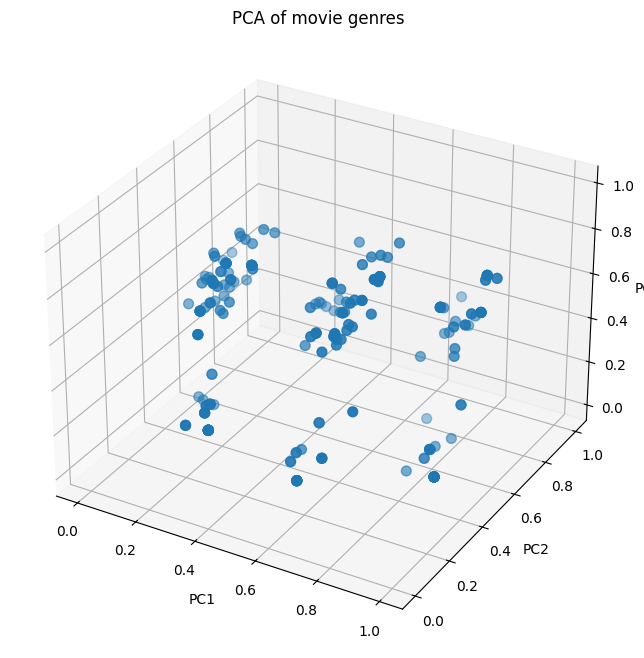

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

#print movies reduced genres
for movie in movies_reduced.values():
    if movie.genres:
        # Create a dataframe for movies and their genres
        movie_genres = {movie.title: movie.genres for movie in movies_reduced.values()}
        df_genres = pd.DataFrame.from_dict(movie_genres, orient='index').fillna('')

        # One hot encode the genres
        encoder = OneHotEncoder()
        encoded_genres = encoder.fit_transform(df_genres.apply(lambda x: ','.join(x), axis=1).str.get_dummies(sep=',')).toarray()

        # Apply PCA with 3 components
        pca = PCA(n_components=3)
        pca_genres = pca.fit_transform(encoded_genres)

        # Create a dataframe with the PCA components
        df_pca_genres = pd.DataFrame(pca_genres, index=df_genres.index, columns=['PC1', 'PC2', 'PC3'])

#Scale the movie pca genres to be between 0 and 1
df_pca_genres = (df_pca_genres - df_pca_genres.min()) / (df_pca_genres.max() - df_pca_genres.min())

#plot the pca components
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca_genres['PC1'], df_pca_genres['PC2'], df_pca_genres['PC3'], s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of movie genres')
plt.show()

In [16]:
# bag ratings of all movies
for movie in tqdm(movies_reduced.values()):
    movie.bag_ratings()
    # movie.calculate_node_rgb()
    # set the movie rgb to be the PCA components
    if movie.genres:
        movie.node_rgb = df_pca_genres.loc[movie.title].values

100%|██████████| 268/268 [00:05<00:00, 50.37it/s]


In [17]:
from sklearn.metrics import jaccard_score
#make a similarity matrix of all movies by the jacard similarity of their bag of ratings

def jaccard_similarity(bag1, bag2):
    """
    Compute the Jaccard similarity between two bags of ratings
    """
    set1 = set(bag1)
    set2 = set(bag2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0


# Initialize the similarity matrix
similarity_matrix = np.zeros((len(movies_reduced), len(movies_reduced)))

# Compute the similarity matrix
movie_list = list(movies_reduced.values())
for i, movie1 in tqdm(enumerate(movie_list)):
    for j in range(i + 1, len(movie_list)):
        movie2 = movie_list[j]
        bag1 = movie1.bag_ratings()
        bag2 = movie2.bag_ratings()
        similarity = jaccard_similarity(bag1, bag2)
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity  # Symmetric matrix


268it [00:36,  7.29it/s]


Text(0.5, 1.0, 'Jaccard Similarity Matrix')

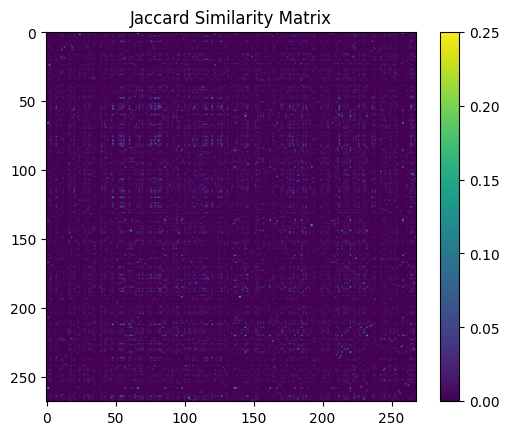

In [18]:
vis_similarities = similarity_matrix.copy()
# Set the diagonal to 0
np.fill_diagonal(vis_similarities, 0)
plt.imshow(vis_similarities, cmap='viridis')
plt.colorbar()
plt.title("Jaccard Similarity Matrix")

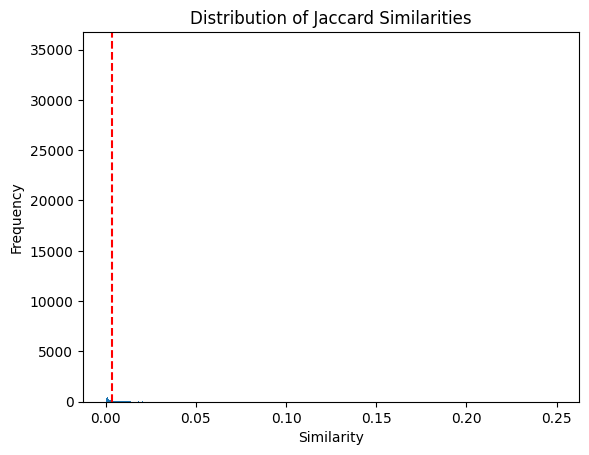

In [19]:
#plot histogram of similarities
plt.hist(vis_similarities.flatten(), bins=5000)
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Jaccard Similarities")
plt.axvline(np.mean(vis_similarities), color="red", linestyle="--", label=f"Mean: {np.mean(vis_similarities):.2f}")
# plt.xlim(0, 1)
plt.show()

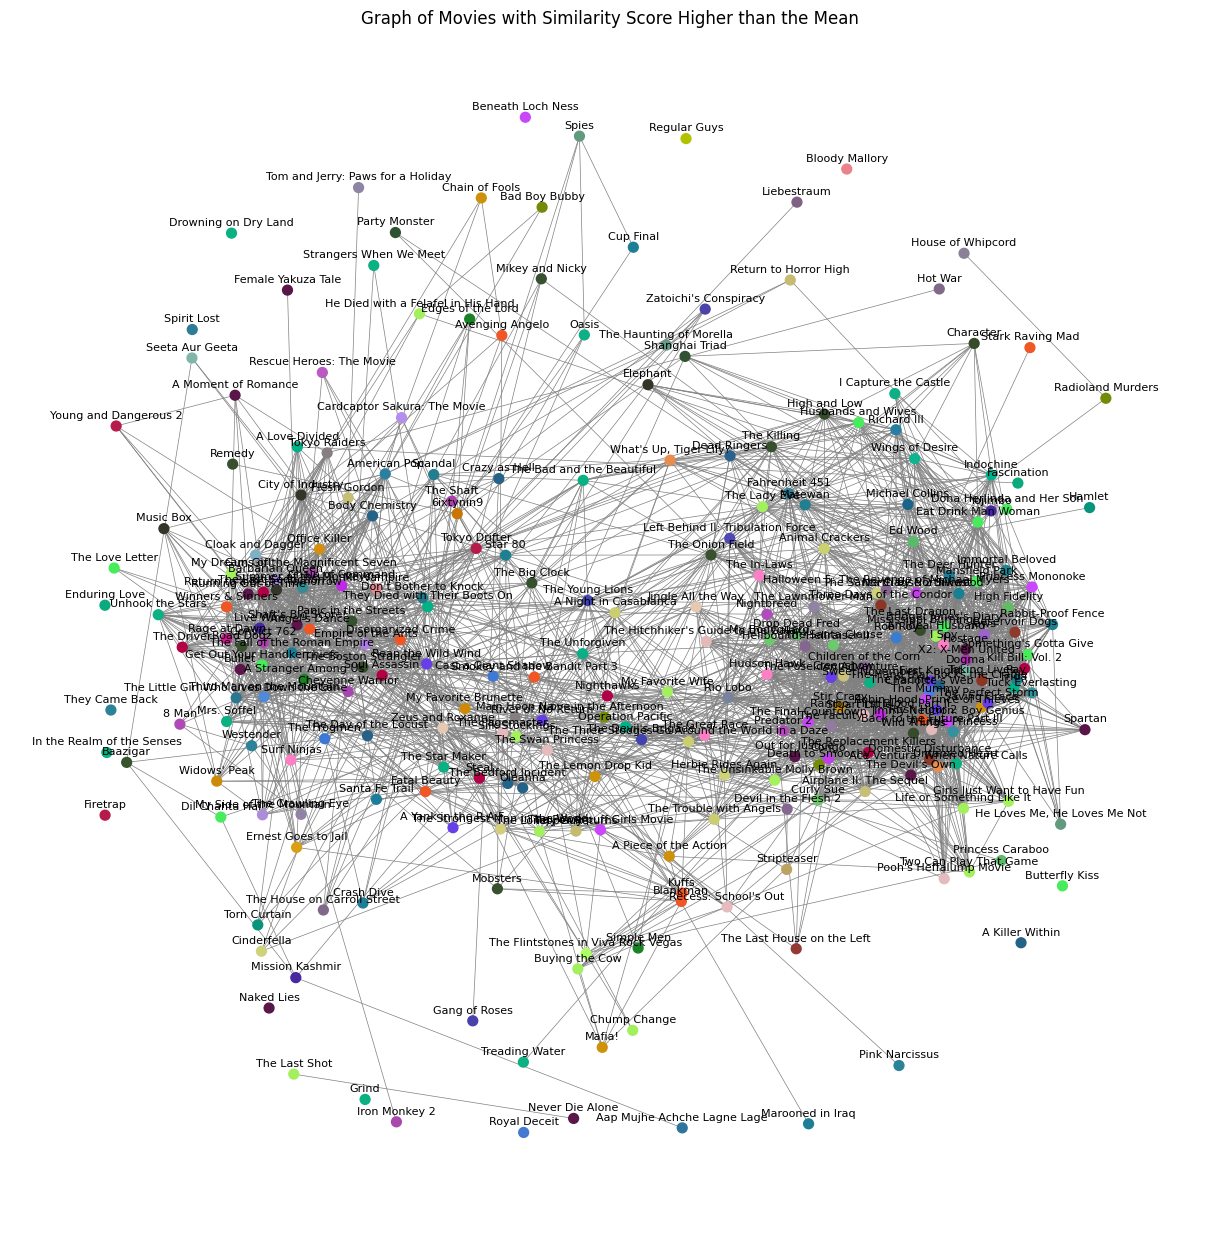

In [46]:
# Calculate the mean similarity score
mean_similarity = np.mean(vis_similarities)
std_similarity = np.std(vis_similarities)

# Create a graph
G = nx.Graph()

# Add nodes
for movie in movies_reduced.values():
    G.add_node(movie.title, rgb=movie.node_rgb)

# Add edges where the similarity score is higher than the mean
for i, movie1 in enumerate(movie_list):
    for j, movie2 in enumerate(movie_list):
        if i < j and vis_similarities[i, j] > mean_similarity + std_similarity:
        # if i < j and vis_similarities[i, j] > 0:
            G.add_edge(movie1.title, movie2.title, weight=similarity_matrix[i, j])

#Assign RGB values to nodes
node_colors = [G.nodes[node]['rgb'] for node in G.nodes]

# Normalize RGB values to [0, 1] range for matplotlib
# node_colors = [(r/255, g/255, b/255) for r, g, b in node_colors]

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, weight='weight', k=0.15)
nx.draw(G, pos, with_labels=False, node_size=50, font_size=8, edge_color='gray', width=0.5, node_color=node_colors)

# Draw the labels above the nodes
label_pos = {key: (value[0], value[1] + 0.02) for key, value in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=8)

plt.title("Graph of Movies with Similarity Score Higher than the Mean")
plt.show()

In [34]:
import netwulf as nw
from matplotlib.colors import to_hex

# Prepare data for Netwulf
netwulf_nodes = []
for node, data in G.nodes(data=True):
    normalized_rgb = tuple([x for x in data['rgb']])
    hex_color = to_hex(normalized_rgb)
    netwulf_nodes.append({
        'id': node,
        'color': hex_color,
        'label': node
    })

netwulf_edges = []
for source, target, data in G.edges(data=True):
    netwulf_edges.append({
        'source': source,
        'target': target,
        'weight': data['weight']
    })

netwulf_graph = {
    'nodes': netwulf_nodes,
    'links': netwulf_edges
}

# Visualize with Netwulf
nw.visualize(netwulf_graph)

(None, None)

In [42]:
from sklearn.cluster import spectral_clustering
import numpy as np
from matplotlib.cm import get_cmap

# Convert the graph to an adjacency matrix
adjacency_matrix = nx.to_numpy_array(G)

# Perform spectral clustering
n_clusters = 10  # You can change the number of clusters
labels = spectral_clustering(adjacency_matrix, n_clusters=n_clusters, eigen_solver='arpack')

# Add the cluster labels to the graph nodes
for i, node in enumerate(G.nodes()):
    G.nodes[node]['cluster'] = labels[i]

# Visualize the clusters
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, weight='weight', k=0.15)
colors = [plt.cm.tab10(i / float(n_clusters)) for i in labels]
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=50, font_size=8, edge_color='gray', width=0.5)

# Draw the labels above the nodes
label_pos = {key: (value[0], value[1] + 0.02) for key, value in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=8)

plt.title("Spectral Clustering of Movies")
plt.show()

# Assign colors to nodes based on their cluster labels
cmap = get_cmap('tab20')
cluster_colors = {i: cmap(i / n_clusters) for i in range(n_clusters)}


# Prepare data for Netwulf
netwulf_nodes = []
for i, (node, data) in enumerate(G.nodes(data=True)):
    cluster_label = labels[i]
    hex_color = to_hex(cluster_colors[cluster_label])
    netwulf_nodes.append({
        'id': node,
        'color': hex_color,
        'label': node
    })

netwulf_edges = []
for source, target, data in G.edges(data=True):
    netwulf_edges.append({
        'source': source,
        'target': target,
        'weight': data['weight']
    })

netwulf_graph = {
    'nodes': netwulf_nodes,
    'links': netwulf_edges
}

# Visualize with Netwulf
nw.visualize(netwulf_graph)


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq\\backend\\cython\\checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


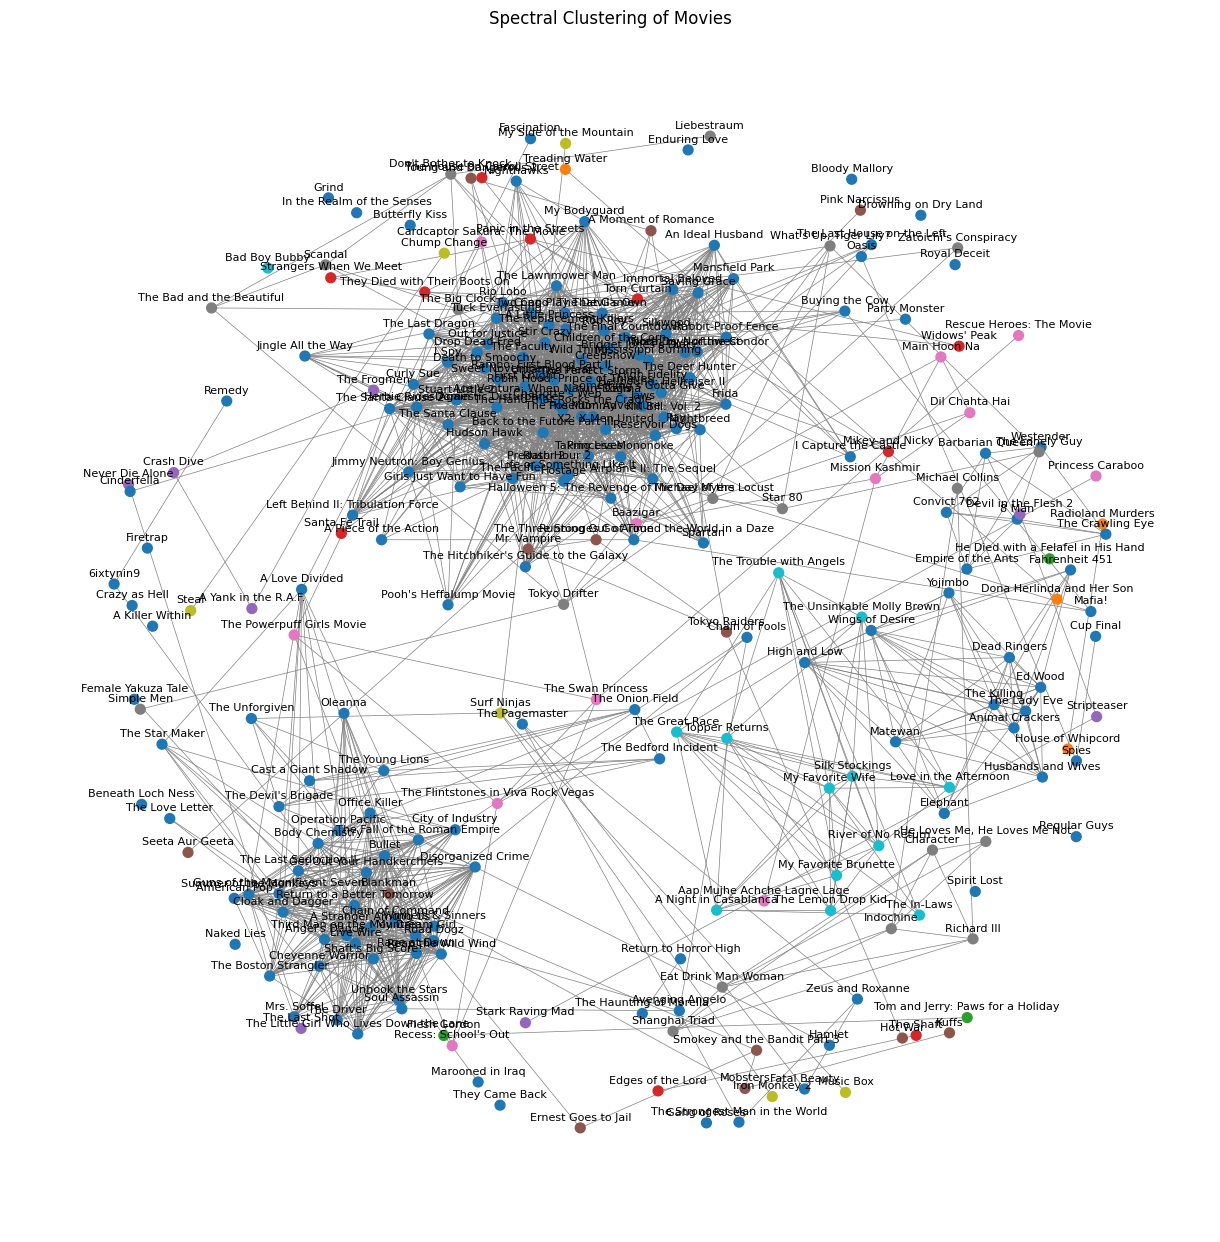

C:\Users\lucas\AppData\Local\Temp\ipykernel_19600\1419961429.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


(None, None)

In [48]:
# datafrom sklearn.cluster import spectral_clustering
# import numpy as np
# from matplotlib.cm import get_cmap
# import matplotlib.pyplot as plt
# import networkx as nx
# from matplotlib.colors import to_hex
# import netwulf as nw

# Assuming G is already defined and contains the graph

# Convert the graph to an adjacency matrix
adjacency_matrix = nx.to_numpy_array(G)

# Perform spectral clustering
n_clusters = 20  # You can change the number of clusters
labels = spectral_clustering(adjacency_matrix, n_clusters=n_clusters, eigen_solver='arpack')

# Add the cluster labels to the graph nodes
for i, node in enumerate(G.nodes()):
    G.nodes[node]['cluster'] = labels[i]

# Remove edges between nodes in different clusters
edges_to_remove = [(source, target) for source, target in G.edges() if G.nodes[source]['cluster'] != G.nodes[target]['cluster']]
G.remove_edges_from(edges_to_remove)

# Visualize the clusters with NetworkX
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, weight='weight', k=0.15)
colors = [plt.cm.tab10(i / float(n_clusters)) for i in labels]
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=50, font_size=8, edge_color='gray', width=0.5)

# Draw the labels above the nodes
label_pos = {key: (value[0], value[1] + 0.02) for key, value in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=8)

plt.title("Spectral Clustering of Movies")
plt.show()

# Assign colors to nodes based on their cluster labels
cmap = get_cmap('tab20')
cluster_colors = {i: cmap(i / n_clusters) for i in range(n_clusters)}

# Prepare data for Netwulf
netwulf_nodes = []
for node, data in G.nodes(data=True):
    # Normalize RGB values to [0, 1] range
    normalized_rgb = tuple([x for x in data['rgb']])
    hex_color = to_hex(normalized_rgb)
    netwulf_nodes.append({
        'id': node,
        'color': hex_color,
        'label': node
    })

netwulf_edges = []
for source, target, data in G.edges(data=True):
    netwulf_edges.append({
        'source': source,
        'target': target,
        'weight': data['weight']
    })

netwulf_graph = {
    'nodes': netwulf_nodes,
    'links': netwulf_edges
}

# Visualize with Netwulf
nw.visualize(netwulf_graph)

In [37]:
normalized_rgb

(0.0010909958190591135, 0.0006185198712096673, 0.002471097800120865)